In [ ]:
pip install git+https://github.com/openai/whisper.git

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-vo6plpnr
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-vo6plpnr
  Resolved https://github.com/openai/whisper.git to commit ba3f3cd54b0e5b8ce1ab3de13e32122d0d5f98ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install fairseq


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New Section

In [ ]:
import whisper

model = whisper.load_model("large-v3")

In [ ]:
model.device

device(type='cpu')

In [ ]:
from IPython.display import Audio

Audio('/content/drive/MyDrive/Colab Notebooks/CUSTOM_DATASET/Speaker18/04_04_01_01_18.wav')

In [ ]:
# load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio("/content/drive/MyDrive/Colab Notebooks/CUSTOM_DATASET/Speaker18/04_04_01_01_18.wav")
audio = whisper.pad_or_trim(audio)

# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio=audio, n_mels=128)


# detect the spoken language
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")

# decode the audio
options = whisper.DecodingOptions(fp16 = False)

result = whisper.decode(model, mel, options)

# print the recognized text
print(result.text)

Detected language: en
Place is on fire. Please send help.


In [ ]:
pip install liqfit sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 44.2 MB/s eta 0:00:00


In [ ]:
from liqfit.pipeline import ZeroShotClassificationPipeline
from liqfit.models import T5ForZeroShotClassification
from transformers import T5Tokenizer

model = T5ForZeroShotClassification.from_pretrained('knowledgator/comprehend_it-multilingual-t5-base')
tokenizer = T5Tokenizer.from_pretrained('knowledgator/comprehend_it-multilingual-t5-base')
classifier = ZeroShotClassificationPipeline(model=model, tokenizer=tokenizer,
                                                      hypothesis_template = '{}', encoder_decoder = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

You are using a model of type T5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys
import tensorflow as tf

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore"
                         )

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
data = '/content/drive/MyDrive/Colab Notebooks/CUSTOM_DATASET'

dir_list = os.listdir(data)
dir_list.sort()

emotion = []
path = []
for i in dir_list:
    sub_dir_path = os.path.join(data, i)
    if os.path.isdir(sub_dir_path):
        fname = os.listdir(sub_dir_path)
        for f in fname:
            if f.endswith('.wav'):
                part = f.split('.')[0].split('_')
                emotion.append(int(part[0]))
                file_path = os.path.join(sub_dir_path, f)
                path.append(file_path)


In [ ]:
def text_num_split(item):
    for index, letter in enumerate(item, 0):
        if letter.isdigit():
            return [item[:index],item[index:]]

In [ ]:
  df = pd.DataFrame(emotion)
  map_dict = {1:'angry', 2:'drunk', 3:'painful', 4:'stressful'}
  df.columns = ['Emotion']
  df["Emotion"] = df['Emotion'].map(map_dict)
  df = pd.concat([df,pd.DataFrame(path, columns = ['path'])],axis=1)
  df.Emotion.value_counts()

angry        87
stressful    87
painful      86
drunk        78
Name: Emotion, dtype: int64

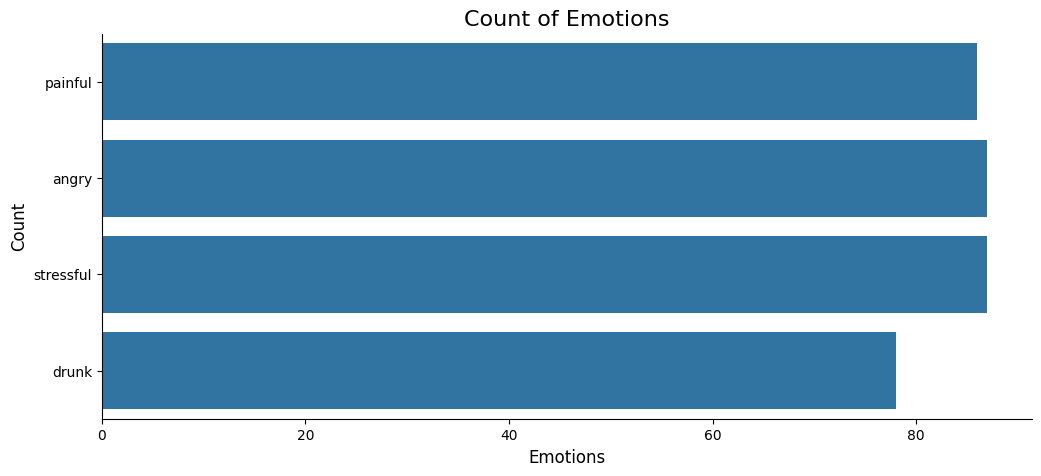

In [ ]:
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(df.Emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [ ]:
path = np.array(df['path'])[217]
data, sample_rate = librosa.load(path)

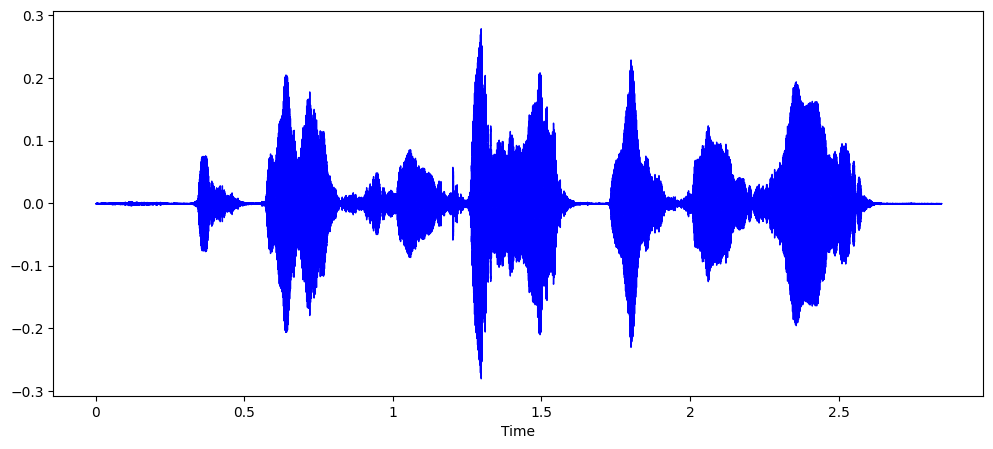

In [ ]:
# NORMAL AUDIO
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sample_rate, color='b')
Audio(path)

In [ ]:
def feat_ext(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_ext(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data)
    result = np.vstack((result, res2))
    #data with stretch and pitch
    new_data = librosa.effects.time_stretch(data, rate=2.0)
    data_stretch_pitch = librosa.effects.pitch_shift(new_data, sr=sample_rate, n_steps=4)
    res3 = feat_ext(data_stretch_pitch)
    result = np.vstack((result, res3))
    return result

In [ ]:
df.head()
df['path'][0]

'/content/drive/MyDrive/Colab Notebooks/CUSTOM_DATASET/Speaker1/03_01_01_01_01.wav'

In [ ]:
X, Y = [], []
for path, emotion in zip(df['path'], df['Emotion']):
    feature = get_feat(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-381.302338,126.568008,-16.986301,42.757381,10.684444,6.611875,1.671685,-28.626720,-3.406556,0.445356,...,4.425558,-12.319290,2.660482,-10.122093,-23.619936,-5.151012,-11.472589,-0.376294,16.852161,painful
1,-164.459473,28.640162,2.756067,10.392079,7.928542,-0.852642,-4.034028,-5.864135,-1.483345,-2.005810,...,-3.299872,-3.887430,-5.498813,-7.766665,-7.144029,-3.750849,-4.536582,-1.254344,6.915684,painful
2,-367.477570,117.492752,-42.499241,47.348942,-13.151317,-1.000214,-16.124306,-13.187356,17.709463,-23.552355,...,-21.363794,-9.793379,-15.896272,-7.588248,18.038168,7.746657,33.509724,8.640950,0.465654,painful
3,-324.718018,149.887573,-17.795889,33.855377,-3.273965,15.846525,14.925138,-6.633807,6.166164,-4.605432,...,-7.840011,-21.723026,-1.319237,-6.773161,-18.949520,-8.675773,-9.729398,-4.259977,-7.862789,angry
4,-220.990285,59.274281,11.701415,18.645350,9.649094,7.031794,8.077386,1.640748,1.746761,-4.090180,...,-9.733967,-13.798619,-7.463706,-7.631385,-14.141708,-9.541012,-8.681263,-7.537669,-6.966160,angry


In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
Features['labels'].values

array(['painful', 'painful', 'painful', ..., 'painful', 'painful',
       'painful'], dtype=object)

In [ ]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0, shuffle=True)

print("Training set shapes:")
print(x_train.shape, y_train.shape)
print("Validation set shapes:")
print(x_val.shape, y_val.shape)
print("Testing set shapes:")
print(x_test.shape, y_test.shape)

Training set shapes:
(648, 20) (648, 4)
Validation set shapes:
(163, 20) (163, 4)
Testing set shapes:
(203, 20) (203, 4)


In [ ]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_valcnn= np.expand_dims(x_val, axis=2)
x_traincnn.shape, y_train.shape, x_valcnn.shape, y_val.shape

((648, 20, 1), (648, 4), (163, 20, 1), (163, 4))

In [ ]:
from liqfit.pipeline import ZeroShotClassificationPipeline
from liqfit.models import T5ForZeroShotClassification
from transformers import T5Tokenizer

model = T5ForZeroShotClassification.from_pretrained('knowledgator/comprehend_it-multilingual-t5-base')
tokenizer = T5Tokenizer.from_pretrained('knowledgator/comprehend_it-multilingual-t5-base')
classifier = ZeroShotClassificationPipeline(model=model, tokenizer=tokenizer,
                                                      hypothesis_template = '{}', encoder_decoder = True)


You are using a model of type T5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


In [ ]:
sequence_to_classify = "Place is on fire. Please send help"
candidate_labels = ['angry', 'drunk','painful','stressful']
classifier(sequence_to_classify, candidate_labels, multi_label=False)


{'sequence': 'Place is on fire. Please send help',
 'labels': ['stressful', 'painful', 'angry', 'drunk'],
 'scores': [0.457623690366745,
  0.38979604840278625,
  0.14521902799606323,
  0.007361157331615686]}